# GAN Homework

В этом ноутбуке вам необходимо будет дополнить ячейки своим кодом в результате чего вы получите первую генеративно-состязательную сеть (GAN). 

Ваша цель - построить и обучить модель GAN, которая генерирует рукописные цифры. Для построения данной модели мы будем использовать фреймворк PyTorch. 

Документацию по нему можно найти [здесь](https://pytorch.org/docs/stable/index.html).

### Что необходимо сделать?

1. Построить с нуля генератор и дискриминатор для GAN.

2. Создать функции потерь для генератора и дискриминатора

3. Обучить GAN и визуализировать результаты

### Решение:

Импортируем необходимые библиотеки и реализуем функцию для визуализации результатов.

Почитать про dataset MNIST можно [тут](https://en.wikipedia.org/wiki/MNIST_database).

In [4]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Функция для визуализации изображений. На вход подается:
    - тензор изображений
    - количество изображений
    - размер каждого изображения
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Cлой генератора

Напишите функцию для создания одного слоя генератора (нейросети). Слой должен содержать: [линейное преобразование](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) для отображения в другой размер, [пакетную нормализацию](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) для стабилизации и нелинейную функцию активации (в нашем случае мы хотим использовать [ReLU](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)).

In [5]:
def get_generator_block(input_dim, output_dim):
    '''
    Функция возвращает блок генератора (нейросети).
    Параметры:
        input_dim: размер входного вектора (скаляр)
        output_dim: размер выходного вектора (скаляр)
    Возвращаемое значение:
        Слой генератора (нейросети), с линейным преобразованием,
        пакетной нормализацией и функцией активации ReLU
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )

#### Функция для проверки:

In [6]:
def test_gen_block(in_features, out_features, num_test=10000):
    block = get_generator_block(in_features, out_features)

    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    assert type(block[2]) == nn.ReLU
    
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    assert tuple(test_output.shape) == (num_test, out_features)
    assert 0.55 < test_output.std() < 0.6


min_shape = 10
max_shape = 40
for i in range(min_shape, max_shape):
    for j in range(min_shape, max_shape):
        test_gen_block(i, j)

### Генератор

Теперь мы можем построить модель генератор целиком. Она принимает три значения:    

- Размер вектора шума
- Размер изображения
- Размер внутреннего слоя 

Генератор - нейронная сеть с 5 слоями. На вход генератор принимает вектор шума и применяя нелинейные преобразования с помощью  блочной генеративной функции до тех пор, пока размер тензора не совпадет с размером нашего изображения.

Необходимо заполнить код последнего слоя, так как он отличается от других. Он не нуждается в функции нормализации или активации, но его необходимо масштабировать с помощью сигмоиды.

In [7]:
class Generator(nn.Module):
    '''
    Генератор
    Значения:
        z_dim: размер вектора шума (скаляр)
        im_dim: размер изображений (скаляр)
          (Изображения из датасета имеют размер MNIST - 1 х 28 x 28 = 784)
        hidden_dim: внутренняя размерность (скаляр)
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Построение нейросети
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Функция для выполнения шага forward у генератора: принимает вектор шума,
            возвращает сгенерированное изображение.
        Параметры:
            noise: тензор шума имеющий размерность (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Возвращает модель генератор
        '''
        return self.gen

#### Функция для проверки:

In [8]:
def test_generator(z_dim, im_dim=784, hidden_dim=124, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()

    assert len(gen) == 6
    assert str(gen.__getitem__(4)).replace(' ', '') == (f'Linear(in_features' + 
                         f'={hidden_dim * 8},' + 
                         f'out_features={im_dim},' + 
                         f'bias=True)') 
    assert str(gen.__getitem__(5)).replace(' ', '') == 'Sigmoid()'
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
test_generator(10)
test_generator(100)
test_generator(200)

### Шум

Чтобы иметь возможность использовать генератор, нам необходимо научиться создавать векторы шума. Вектор шума $z$ играет важную рольв обеспечении того, чтобы изображения, созданные из одного класса не выглядели одинаково.

Вам необходимо сгенерировать его случайным образом, используя **PyTorch**, путем выборки случайных чисел из нормального распределения.

Поскольку за один проход будет сгенерировано несколько изображений, необходимо сгенерировать все векторы шума одновременно.

In [9]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Функция для генерации векторов шума: даны размеры векторов 
    (n_samples, z_dim), создает векторы заполненные произвольными значениями 
    из нормального распределения.
    Параметры:
        n_samples: количество сэмплов для генерации (скаляр)
        z_dim: размерность вектора шума (скаляр)
        device: тип устройства на котором будем генерировать векторы шума.
    '''
    #### START CODE HERE ####
    return torch.randn(n_samples, z_dim, device=device)
    #### END CODE HERE ####

In [10]:
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)
    
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    for i in range(1000):
        test_get_noise(1000, i, 'cuda')

### Слой дискриминатора

Напишите функцию для создания одного слоя дискриминатора (нейросети). Слой должен содержать: [линейное преобразование](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) для отображения в другой размер и нелинейную функцию активации (в нашем случае мы хотим использовать [Leaky ReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)).

*Замечание*: мы хотим использовать в качестве функции активации Leaky ReLU, чтобы избежать проблемы, когда параметры перестают меняться из-за последовательно отрицательных значений, передаваемых в ReLU, что приводит к нулевому градиенту

In [11]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Функция возвращающая слой дискриминатора (нейросети).
    Параметры:
        input_dim: размер входного вектора (скаляр)
        output_dim: размер выходного вектора (скаляр)
    Возвращаемое значение:
        слой дискриминатора, сожержащий линейное преобразование 
        из входного размера в выходной с функцией активации LeakyReLU 
        с параметром negative_slope = 0.2
    '''
    return nn.Sequential(
        #### START CODE HERE ####
         nn.Linear(input_dim, output_dim),
         nn.LeakyReLU(0.2, inplace=True)
        #### END CODE HERE ####
    )

In [12]:
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    assert tuple(test_output.shape) == (num_test, out_features)
    
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5
    
    assert str(block.__getitem__(0)).replace(' ', '') == (f'Linear(' +
        f'in_features={in_features},out_features={out_features},bias=True)')        
    assert str(block.__getitem__(1)).replace(' ', '').replace(
        ',inplace=True', '') == 'LeakyReLU(negative_slope=0.2)'


min_shape = 10
max_shape = 40
for i in range(min_shape, max_shape):
    for j in range(min_shape, max_shape):
        test_gen_block(i, j)

### Дискриминатор

Класс дискриминатора принимает в конструкторе два значения:    

- Размер изображения
- Размер скрытого измерения

Дискриминатор - нейронная сеть из 4 слоев. Он принимает на вход тензор изображения и преобразует его до тех пор, пока не получит 1 число (0 - фейковое изображение, 1 - реальное изображение).

Обратите внимание, что вам не нужна сигмоида после выходного слоя, так как она включена в функцию потерь.

Необходимо заполнить код последнего слоя.

In [13]:
class Discriminator(nn.Module):
    '''
    Дискриминатор
    Значения:
        im_dim: размер изображений (скаляр)
            (Изображения из датасета имеют размер MNIST - 1 х 28 x 28 = 784)
        hidden_dim: размер скрытого слоя (скаляр)
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Функция для выполнения шага forward в модели дискриминатора:
        Дан тензор изображения, вернуть тензор размерности 1 
        является ли это картинка фейком или нет.
        Parameters:
            image: плоский тензор изображения с размером (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Возвращаемое значение:
            модель дискриминатор
        '''
        return self.disc

#### Функция для проверки:

In [14]:
def test_discriminator(z_dim, hidden_dim=128, num_test=100):
    
    disc = Discriminator(z_dim, hidden_dim).get_disc()

    assert len(disc) == 4
    assert type(disc.__getitem__(3)) == nn.Linear

    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

test_discriminator(5, 10)
test_discriminator(20, 8)
test_discriminator(10)
test_discriminator(50)
test_discriminator(100)
test_discriminator(200)

### Обучение

Теперь мы можем собрать нашу реализацию GAN.

Во-первых, необходимо установить параметры:

- `criterion` - функция потерь
- `n_epochs` - количество раз, которое необходимо проитерировать весь датасет во время обучения
- `z_dim` - размерность вектора шума
- `display_step` - раз в сколько шагов необходимо визуализировать процесс
- `batch_size` - количество картинок, обрабатываемых во время шагов `forward` и `backward`
- `lr` - learning rate
- `device` - тип устройства

Во-вторых, необходимо загрузить датасет MNIST с помощью `dataloader`

In [15]:
# Можно установить свои параметры
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cpu'
# Загрузка датасета MNIST как тензоры
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Теперь вы можете инициализировать свой генератор, дискриминатор и оптимизаторы. Обратите внимание, что каждый оптимизатор принимает параметры только одной конкретной модели, так как мы хотим, чтобы каждый из них оптимизировал только одну из моделей.

In [16]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Прежде, чем обучать GAN нам необходимо написать функции, которые вычисляют потери дискриминатора и генератора. 

### Функция активации дискриминатора

Вам необходимо выполнить следующие шаги:

1. Создание векторов шума и генерация пачки (`num_images`) фейковых изображений. Убедитесь, что передаете параметр `device` в функцию `get_noise`.

2. Получить предсказание дискриминатора на фейковых картинках и посчитать значения функции потерь. Не забудьте вызвать метод `detach` у генератора.

3. Получить предсказание дискриминатора на реальных картинках и посчитать значения функции потерь.

4. Вычислите потери дискриминатора в среднем на реальных и фейковых картинках это и будет `disc_loss`.

*Важно*: 

1. Вам нужен тензор "абсолютной истины", чтобы рассчитать потери. Например, тензор абсолютной истинности для фейкового изображения - это все нули.

2. Вам не нужно писать здесь собственную функцию потерь - используйте `criterion(pred, true)`

In [17]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Возвращает потери дискриминатора на заданном вхоже.
    Параметры:
        gen: генератор, который возвращает z-размерный шум
        disc: дискриминатор, который возвращает предсказание - real/fake
        criterion: функция потерь, которая используется дискриминатором 
               для сравнения предсказаний с действительной реальностью картинок 
               (fake = 0, real = 1)
        real: пачка реальных картинок
        num_images: количество картинок созданных генератором, совпадает 
                    с количеством реальных картиное
        z_dim: размерность вектора шума (скаляр)
        device: тип устройства на котором будем запускать
    Возвращаемое значение:
        disc_loss: значения функции потерь для текущей пачки картинок
    '''
    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [18]:
def test_disc_reasonable(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul
    real = torch.ones(num_images, 1)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim,
                              'cpu')
    assert tuple(disc_loss.shape) == (num_images, z_dim)
    assert torch.all(torch.abs(disc_loss - 0.5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul
    real = torch.zeros(num_images, 1)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real,
                                             num_images, z_dim, 'cpu')) < 1e-5)

def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size,
                                  z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        disc_loss.backward(retain_graph=True)

        assert gen.gen[0][0].weight.grad is None

        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()

### Функция активации генератора

Вам необходимо выполнить следующие шаги:

1. Создание векторов шума и генерация пачки (`num_images`) фейковых изображений. Убедитесь, что передаете параметр `device` в функцию `get_noise`.

2. Получить предсказание дискриминатора на фейковых картинках.

3. Вычислите значение потерь генератора. Помните, что генератор хочет, чтобы дискриминатор считал фейковые картинки - реальными.

*Важно*: 

1. Вам нужен тензор "абсолютной истины", чтобы рассчитать потери. Например, тензор абсолютной истинности для фейкового изображения - это все нули.

2. Вам не нужно писать здесь собственную функцию потерь - используйте `criterion(pred, true)`

In [19]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Возвращает значение функции потерь генератора на текущих входных данных.
    Параметры:
        gen: генератор, который возвращает z-размерный шум
        disc: дискриминатор, который возвращает предсказание - real/fake
        criterion: функция потерь, которая используется дискриминатором 
               для сравнения предсказаний с действительной реальностью картинок 
               (fake = 0, real = 1)
        num_images: количество картинок созданных генератором, совпадает 
                    с количеством реальных картиное
        z_dim: размерность вектора шума (скаляр)
        device: тип устройства на котором будем запускать
    Возвращаемое значение:
        gen_loss: тензор со значениями функции потерь генератора 
                  для текущей пачки
    '''
    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss

In [20]:
def test_gen_reasonable(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
    
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)

### Процесс обучения

Для каждой эпохи вы будете обрабатывать весь набор данных пакетно. Для каждой партии вам нужно будет обновить дискриминатор и генератор, используя их потери. Обратите внимание, что вы можете увидеть, что потеря может быть больше 1, это нормально, так как **BCE** (binary cross entropy) может быть любым положительным числом для достаточно уверенного ошибочного предположения.

Также часто бывает так, что дискриминатор превосходит генератор, особенно на старте, потому что его работа проще. Важно, чтобы ни один из них не переобучился.

После того, как вы представили рабочую версию с оригинальной архитектурой, не стесняйтесь поиграть с архитектурой, если вы хотите увидеть, как различные архитектурные решения могут привести к улучшению или ухудшению GAN.

В этом задании вам необходимо реализовать обновление генератора:    

1. Обнулить градиенты
2. Вычислить значение функции потерь генератора и присвоить их в переменную `gen_loss`
3. Обновить градиенты
4. Обновить оптимизатор

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.45090410387516, discriminator loss: 0.41054362058639515


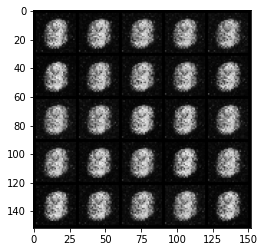

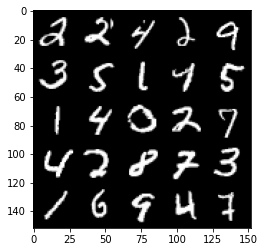

KeyboardInterrupt: ignored

In [21]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size,
                                  z_dim, device)

        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim,
                                device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        if test_generator:
            try:
                assert lr > 0.0000002 or (
                    gen.gen[0][0].weight.grad.abs().max() < 0.0005 
                    and epoch == 0)
                assert torch.any(
                    gen.gen[0][0].weight.detach().clone() 
                    != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}," + 
                  f" discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1